# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using SageMaker Autopilot
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [3]:
#Name
ModelName = 'titanic_propensity_survive'
#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'survived'
VarId = 'passengerid'
VarDate = 'referencedate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#Bucket already created on S3
bucket = 'data-science-lab'

CAT = [
'pclass'
,'embarked'
,'cabine_prefix'
,'ticket_str'
,'nametitle']

#float
NUM = [
'fare'
,'sibsp'
,'parch'
,'age_mean'
,'ticket_int']
selected_features = CAT + NUM

# 2. Import Libraries

In [4]:
import sys
sys.path.append('/var/lang/lib/python37.zip')
sys.path.append('/var/lang/lib/python3.7')
sys.path.append('/var/lang/lib/python3.7/lib-dynload')
sys.path.append('/var/lang/lib/python3.7/site-packages')
sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')

In [28]:
# !pip install h2o==3.36.1.3

In [7]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import awswrangler as wr
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [8]:
#Criar conexão com o Athena
my_boto3_session = boto3.Session(region_name='us-east-1')

In [9]:
query4="select * from datascience.%s" % ModelName
dataprep_df_full = wr.athena.read_sql_query(query4, database="datascience", boto3_session=my_boto3_session, s3_output='s3://query-temp-result')

In [10]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [11]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

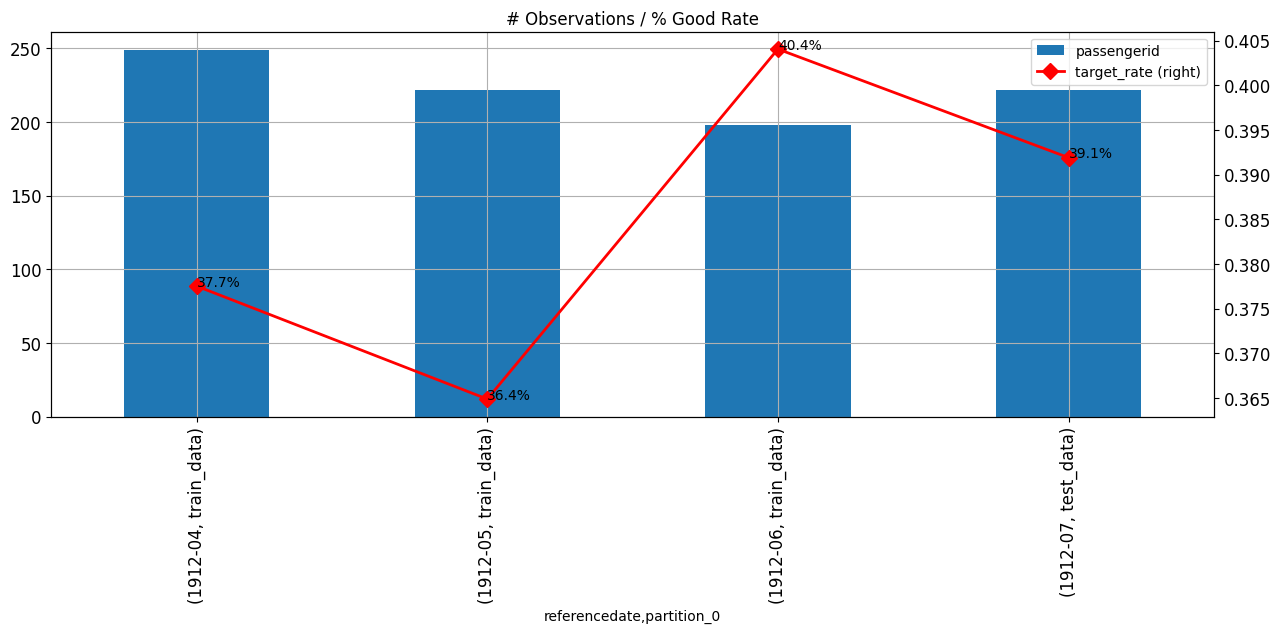

In [12]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'partition_0']].groupby(by=[VarDate, 'partition_0']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]


dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [13]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [14]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [15]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Traning Models with SageMaker Autopilot

### 4.1.1 SageMaker Setup

In [73]:
# region = my_boto3_session.region_name
# session = sagemaker.Session(my_boto3_session)

# # You can modify the following to use a bucket of your choosing
# prefix = "models/%s/sagemaker-temp" % ModelName

# role = get_execution_role()

# # # This is the client we will use to interact with SageMaker AutoPilot
# sm = my_boto3_session.client(service_name="sagemaker", region_name=region)

# input_data_config = [
#     {
#         "DataSource": {
#             "S3DataSource": {
#                 "S3DataType": "S3Prefix",
#                 "S3Uri": 's3://%s/databases/%s/train_data/train_data.csv' % (bucket, ModelName),
#             }
#         },
#         "TargetAttributeName": VarTarget,
#     }
# ]

# output_data_config = {"S3OutputPath": "s3://%s/%s" % (bucket, prefix)}

### 4.1.2 SageMaker Setup and Run Auto Pilot

In [74]:
# timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())

# auto_ml_job_name = "autopilot-" + ModelName.replace('_', '-')[0:10] + '-' + timestamp_suffix
# print("AutoMLJobName: " + auto_ml_job_name)

# #Run SageMaker Autopilot
# sm.create_auto_ml_job(
#     AutoMLJobName=auto_ml_job_name,
#     InputDataConfig=input_data_config,
#     OutputDataConfig=output_data_config,
#     AutoMLJobConfig={"CompletionCriteria": {"MaxCandidates": 20}},
#     RoleArn=role
# )

In [75]:
# print("JobStatus - Secondary Status")
# print("------------------------------")

# describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
# print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime()))
# job_run_status = describe_response["AutoMLJobStatus"]

# while job_run_status not in ("Failed", "Completed", "Stopped"):
#     describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
#     job_run_status = describe_response["AutoMLJobStatus"]

#     print(
#         describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime())
#     )
#     sleep(30)

### 4.1.3 Create SageMaker Endpoint and Predictor with the Best Candidate

In [76]:
# #Select best candidate
# best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)["BestCandidate"]
# best_candidate_name = best_candidate["CandidateName"]

# #Add probability and probabilities to the SAGEMAKER_INFERENCE_OUTPUT
# for i in range(len(best_candidate["InferenceContainers"])):
#     best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_INPUT']='predicted_label, probability, probabilities'
#     best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_OUTPUT']='predicted_label, probability, probabilities'

# #Create endpoint configuration
# timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
# model_name = best_candidate_name + timestamp_suffix + "-model"
# model_arn = sm.create_model(
#     Containers=best_candidate["InferenceContainers"], ModelName=model_name, ExecutionRoleArn=role
# )

# epc_name = best_candidate_name + timestamp_suffix + "-epc"
# ep_config = sm.create_endpoint_config(
#     EndpointConfigName=epc_name,
#     ProductionVariants=[
#         {
#             "InstanceType": "ml.m5.2xlarge",
#             "InitialInstanceCount": 1,
#             "ModelName": model_name,
#             "VariantName": "main",
#         }
#     ],
# )

# #Create end endpoint
# ep_name = best_candidate_name + timestamp_suffix + "-ep"
# create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
# sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
# print("ep_name: " + str(ep_name))

In [77]:
# #Create Predictor
# sm_predictor = Predictor(
#     endpoint_name=ep_name,
#     sagemaker_session=session,
#     serializer=CSVSerializer(),
#     deserializer=CSVDeserializer(),
# )

## 4.2 Traning Models with H2O AutoML

## 4.2.1 Creating context and H2O and Importing data into the H2O context

In [16]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '4G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_342"; OpenJDK Runtime Environment Corretto-8.342.07.4 (build 1.8.0_342-b07); OpenJDK 64-Bit Server VM Corretto-8.342.07.4 (build 25.342-b07, mixed mode)
  Starting server from /var/lang/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp63u6rw2n
  JVM stdout: /tmp/tmp63u6rw2n/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp63u6rw2n/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,2 months and 9 days
H2O_cluster_name:,H2O_from_python_unknownUser_i1ta9g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [17]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "train_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 605
Validation: 64


In [18]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 222


## 4.2.2 Train the H2O Champion algorithm with new data

In [19]:
# h2o_champion = h2o.load_model('StackedEnsemble_BestOfFamily_3_AutoML_1_20220713_190002')
# h2o_champion

In [20]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='h2o_champion_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o_champion = H2OGradientBoostingEstimator(model_id='%s%s_%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                    nfolds= 5,
                                    keep_cross_validation_models= False,
                                    keep_cross_validation_predictions= True,
                                    keep_cross_validation_fold_assignment= False,
                                    score_each_iteration= False,
                                    score_tree_interval= 5,
                                    fold_assignment='Modulo',
                                    fold_column= None,
                                    ignore_const_cols= True,
                                    offset_column= None,
                                    weights_column= None,
                                    balance_classes= False,
                                    class_sampling_factors= None,
                                    max_after_balance_size= 5.0,
                                    max_confusion_matrix_size= 20,
                                    ntrees= 120,
                                    max_depth= 4,
                                    min_rows= 100.0,
                                    nbins= 20,
                                    nbins_top_level= 1024,
                                    nbins_cats= 1024,
                                    r2_stopping= 1.7976931348623157e+308,
                                    stopping_rounds= 2,
                                    stopping_metric='AUCPR',
                                    stopping_tolerance= 0.002303474948339114,
                                    max_runtime_secs= 31688.0,
                                    seed= 101,
                                    build_tree_one_node= False,
                                    learn_rate= 0.1,
                                    learn_rate_annealing= 1.0,
                                    distribution='bernoulli',
                                    quantile_alpha= 0.5,
                                    tweedie_power= 1.5,
                                    huber_alpha= 0.9,
                                    checkpoint= None,
                                    sample_rate= 0.9,
                                    sample_rate_per_class= None,
                                    col_sample_rate= 0.4,
                                    col_sample_rate_change_per_level= 1.0,
                                    col_sample_rate_per_tree= 0.7,
                                    min_split_improvement= 1e-05,
                                    histogram_type='UniformAdaptive',
                                    max_abs_leafnode_pred= 1.7976931348623157e+308,
                                    pred_noise_bandwidth= 0.0,
                                    categorical_encoding='Enum',
                                    calibrate_model= False,
                                    calibration_frame= None,
                                    custom_metric_func= None,
                                    custom_distribution_func= None,
                                    export_checkpoints_dir= None,
                                    monotone_constraints= None,
                                    check_constant_response= True,
                                    gainslift_bins= -1,
                                    auc_type='AUTO',
                                    interaction_constraints= None)

# The use of a validation_frame is recommended with using early stopping
h2o_champion.train(x=selected_features, y=VarTarget, training_frame=train_hdf, validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(h2o_champion)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:03.645562

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  h2o_champion_titanic_propensity_survive_v18_20220917_193952


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,51.0,51.0,5198.0,1.0,4.0,2.333333,2.0,5.0,3.431373




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.12877439774017585
RMSE: 0.3588514981718425
LogLoss: 0.4176219523855519
Mean Per-Class Error: 0.16621621621621624
AUC: 0.8934732604945371
AUCPR: 0.8722395772406651
Gini: 0.7869465209890742

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47039414887507597: 


,,0,1,Error,Rate
0,0,321.0,49.0,0.1324,(49.0/370.0)
1,1,47.0,188.0,0.2,(47.0/235.0)
2,Total,368.0,237.0,0.1587,(96.0/605.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.470394,0.796610,185.0
1,max f2,0.323346,0.826645,236.0
2,max f0point5,0.550180,0.835897,149.0
3,max accuracy,0.550180,0.844628,149.0
4,max precision,0.902118,1.000000,0.0
5,max recall,0.079121,1.000000,382.0
6,max specificity,0.902118,1.000000,0.0
7,max absolute_mcc,0.550180,0.670844,149.0
8,max min_per_class_accuracy,0.426921,0.824324,206.0
9,max mean_per_class_accuracy,0.470394,0.833784,185.0



Gains/Lift Table: Avg response rate: 38.84 %, avg score: 38.73 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011570,0.889803,2.574468,2.574468,1.000000,0.895601,1.000000,0.895601,0.029787,0.029787,157.446809,157.446809,0.029787
1,2,0.021488,0.880931,2.574468,2.574468,1.000000,0.886055,1.000000,0.891195,0.025532,0.055319,157.446809,157.446809,0.055319
2,3,0.031405,0.867250,2.574468,2.574468,1.000000,0.873083,1.000000,0.885476,0.025532,0.080851,157.446809,157.446809,0.080851
3,4,0.041322,0.861364,2.574468,2.574468,1.000000,0.864065,1.000000,0.880337,0.025532,0.106383,157.446809,157.446809,0.106383
4,5,0.051240,0.852200,2.574468,2.574468,1.000000,0.857271,1.000000,0.875873,0.025532,0.131915,157.446809,157.446809,0.131915
5,6,0.102479,0.809959,2.408373,2.491421,0.935484,0.832858,0.967742,0.854365,0.123404,0.255319,140.837337,149.142073,0.249914
6,7,0.150413,0.728717,2.396919,2.461305,0.931034,0.767046,0.956044,0.826538,0.114894,0.370213,139.691856,146.130465,0.359402
7,8,0.200000,0.664492,2.574468,2.489362,1.000000,0.694472,0.966942,0.793795,0.127660,0.497872,157.446809,148.936170,0.487062
8,9,0.300826,0.554368,1.814789,2.263269,0.704918,0.606758,0.879121,0.731106,0.182979,0.680851,81.478898,126.326865,0.621392
9,10,0.400000,0.457813,1.201418,2.000000,0.466667,0.508960,0.776860,0.676029,0.119149,0.800000,20.141844,100.000000,0.654054




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.1749301506445585
RMSE: 0.4182465189867795
LogLoss: 0.529830100028745
Mean Per-Class Error: 0.27954545454545454
AUC: 0.7534090909090909
AUCPR: 0.6596599821338213
Gini: 0.5068181818181818

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1596358282615121: 


,,0,1,Error,Rate
0,0,26.0,18.0,0.4091,(18.0/44.0)
1,1,3.0,17.0,0.15,(3.0/20.0)
2,Total,29.0,35.0,0.3281,(21.0/64.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.159636,0.618182,32.0
1,max f2,0.139856,0.750000,37.0
2,max f0point5,0.701866,0.714286,8.0
3,max accuracy,0.701866,0.796875,8.0
4,max precision,0.883684,1.000000,0.0
5,max recall,0.072821,1.000000,55.0
6,max specificity,0.883684,1.000000,0.0
7,max absolute_mcc,0.701866,0.503030,8.0
8,max min_per_class_accuracy,0.226556,0.681818,25.0
9,max mean_per_class_accuracy,0.159636,0.720455,32.0



Gains/Lift Table: Avg response rate: 31.25 %, avg score: 31.14 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015625,0.875954,3.200000,3.200000,1.000000,0.883684,1.000000,0.883684,0.05,0.05,220.000000,220.000000,0.050000
1,2,0.031250,0.854478,3.200000,3.200000,1.000000,0.871415,1.000000,0.877549,0.05,0.10,220.000000,220.000000,0.100000
2,3,0.031250,0.813439,0.000000,3.200000,0.000000,0.000000,1.000000,0.877549,0.00,0.10,-100.000000,220.000000,0.100000
3,4,0.046875,0.797916,3.200000,3.200000,1.000000,0.806274,1.000000,0.853791,0.05,0.15,220.000000,220.000000,0.150000
4,5,0.062500,0.787063,0.000000,2.400000,0.000000,0.790200,0.750000,0.837893,0.00,0.15,-100.000000,140.000000,0.127273
5,6,0.109375,0.743133,3.200000,2.742857,1.000000,0.758943,0.857143,0.804057,0.15,0.30,220.000000,174.285714,0.277273
6,7,0.156250,0.653093,2.133333,2.560000,0.666667,0.705418,0.800000,0.774466,0.10,0.40,113.333333,156.000000,0.354545
7,8,0.203125,0.581415,1.066667,2.215385,0.333333,0.595319,0.692308,0.733124,0.05,0.45,6.666667,121.538462,0.359091
8,9,0.296875,0.427255,0.533333,1.684211,0.166667,0.520597,0.526316,0.666010,0.05,0.50,-46.666667,68.421053,0.295455
9,10,0.406250,0.239932,1.371429,1.600000,0.428571,0.324315,0.500000,0.574015,0.15,0.65,37.142857,60.000000,0.354545




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.14435782051542978
RMSE: 0.37994449662474356
LogLoss: 0.45729453202410214
Mean Per-Class Error: 0.20172512938470386
AUC: 0.8673202990224267
AUCPR: 0.8303650122602358
Gini: 0.7346405980448534

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42120625253752525: 


,,0,1,Error,Rate
0,0,290.0,80.0,0.2162,(80.0/370.0)
1,1,44.0,191.0,0.1872,(44.0/235.0)
2,Total,334.0,271.0,0.205,(124.0/605.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.421206,0.754941,204.0
1,max f2,0.309050,0.826121,245.0
2,max f0point5,0.586548,0.789474,123.0
3,max accuracy,0.499027,0.814876,156.0
4,max precision,0.914007,1.000000,0.0
5,max recall,0.071422,1.000000,395.0
6,max specificity,0.914007,1.000000,0.0
7,max absolute_mcc,0.499027,0.604138,156.0
8,max min_per_class_accuracy,0.428799,0.795745,198.0
9,max mean_per_class_accuracy,0.421206,0.798275,204.0



Gains/Lift Table: Avg response rate: 38.84 %, avg score: 39.09 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011570,0.874272,2.206687,2.206687,0.857143,0.889941,0.857143,0.889941,0.025532,0.025532,120.668693,120.668693,0.022829
1,2,0.021488,0.859273,2.574468,2.376432,1.000000,0.864098,0.923077,0.878013,0.025532,0.051064,157.446809,137.643208,0.048361
2,3,0.031405,0.839879,2.574468,2.438970,1.000000,0.846115,0.947368,0.867940,0.025532,0.076596,157.446809,143.896976,0.073893
3,4,0.041322,0.820712,2.574468,2.471489,1.000000,0.830954,0.960000,0.859063,0.025532,0.102128,157.446809,147.148936,0.099425
4,5,0.051240,0.808066,2.574468,2.491421,1.000000,0.810210,0.967742,0.849608,0.025532,0.127660,157.446809,149.142073,0.124957
5,6,0.100826,0.759098,2.488652,2.490059,0.966667,0.784739,0.967213,0.817705,0.123404,0.251064,148.865248,149.005930,0.245658
6,7,0.150413,0.700812,2.317021,2.433014,0.900000,0.732085,0.945055,0.789479,0.114894,0.365957,131.702128,143.301379,0.352444
7,8,0.200000,0.624759,2.059574,2.340426,0.800000,0.660776,0.909091,0.757569,0.102128,0.468085,105.957447,134.042553,0.438355
8,9,0.300826,0.541893,1.645971,2.107669,0.639344,0.585596,0.818681,0.699930,0.165957,0.634043,64.597140,110.766893,0.544853
9,10,0.401653,0.437350,1.266132,1.896419,0.491803,0.477863,0.736626,0.644185,0.127660,0.761702,26.613185,89.641888,0.588729




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.829752,0.030701,0.834711,0.851240,0.851240,0.776860,0.834711
1,auc,0.871380,0.039435,0.847460,0.863123,0.906843,0.823278,0.916197
2,err,0.170248,0.030701,0.165289,0.148760,0.148760,0.223140,0.165289
3,err_count,20.600000,3.714835,20.000000,18.000000,18.000000,27.000000,20.000000
4,f0point5,0.773739,0.020812,0.803571,0.761589,0.786517,0.752688,0.764331
5,f1,0.781846,0.045937,0.782609,0.718750,0.823529,0.756757,0.827586
6,f2,0.794102,0.088899,0.762712,0.680473,0.864198,0.760870,0.902256
7,lift_top_group,2.634489,0.481681,2.520833,3.457143,2.574468,2.200000,2.420000
8,logloss,0.455807,0.052033,0.467676,0.461702,0.411803,0.533632,0.404222
9,max_per_class_error,0.251684,0.059856,0.250000,0.342857,0.175676,0.236364,0.253521



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-09-17 19:39:55,2.896 sec,0.0,0.487393,0.668041,0.500000,0.388430,1.000000,0.611570,0.469690,0.633575,0.500000,0.312500,1.000000,0.687500
1,,2022-09-17 19:39:55,2.936 sec,5.0,0.468354,0.629707,0.724117,0.625552,2.076184,0.285950,0.445052,0.585416,0.802841,0.586751,1.066667,0.156250
2,,2022-09-17 19:39:56,2.960 sec,10.0,0.429004,0.554357,0.840736,0.811365,2.413564,0.201653,0.420528,0.539285,0.795455,0.722328,3.200000,0.187500
3,,2022-09-17 19:39:56,2.981 sec,15.0,0.414286,0.526397,0.857798,0.829686,2.574468,0.191736,0.414200,0.526589,0.780682,0.697697,3.200000,0.218750
4,,2022-09-17 19:39:56,3.003 sec,20.0,0.395612,0.490242,0.877355,0.839272,2.252660,0.188430,0.414579,0.524826,0.756818,0.673785,3.200000,0.218750
5,,2022-09-17 19:39:56,3.028 sec,25.0,0.382548,0.465592,0.884658,0.855820,2.574468,0.166942,0.413714,0.521402,0.762500,0.665916,3.200000,0.265625
6,,2022-09-17 19:39:56,3.063 sec,30.0,0.380131,0.460518,0.885624,0.858918,2.574468,0.178512,0.413403,0.520966,0.757955,0.667027,3.200000,0.187500
7,,2022-09-17 19:39:56,3.088 sec,35.0,0.372818,0.445847,0.887108,0.862526,2.574468,0.166942,0.413644,0.520267,0.757955,0.664943,3.200000,0.187500
8,,2022-09-17 19:39:56,3.112 sec,40.0,0.368806,0.437900,0.890081,0.867873,2.574468,0.161983,0.413634,0.520377,0.760227,0.663695,3.200000,0.343750
9,,2022-09-17 19:39:56,3.170 sec,45.0,0.364371,0.429129,0.891737,0.870601,2.574468,0.160331,0.417305,0.527420,0.754545,0.660557,3.200000,0.343750



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,nametitle,202.190674,1.000000,0.585104
1,pclass,37.839146,0.187146,0.109500
2,ticket_int,33.940018,0.167861,0.098216
3,cabine_prefix,31.618309,0.156379,0.091498
4,fare,21.985495,0.108736,0.063622
5,embarked,10.986922,0.054339,0.031794
6,age_mean,4.909112,0.024280,0.014206
7,sibsp,1.426544,0.007055,0.004128
8,parch,0.667556,0.003302,0.001932
9,ticket_str,0.000000,0.000000,0.000000


## 4.2.3 Using H2O AutoML to performe all algorithms

In [21]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*2

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
19:40:24.624: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:02:02.392599



In [22]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
GBM_3_AutoML_1_20220917_194024,0.897827,0.902214,0.366738,0.147893,0.330994,0.109557
GBM_grid_1_AutoML_1_20220917_194024_model_5,0.896783,0.905321,0.360476,0.149936,0.329692,0.108697
GBM_grid_1_AutoML_1_20220917_194024_model_8,0.893883,0.893231,0.38112,0.163091,0.34249,0.1173
StackedEnsemble_AllModels_4_AutoML_1_20220917_194024,0.892662,0.898255,0.366658,0.146999,0.332568,0.110602
StackedEnsemble_AllModels_3_AutoML_1_20220917_194024,0.892452,0.89834,0.366196,0.146999,0.331946,0.110188
StackedEnsemble_BestOfFamily_3_AutoML_1_20220917_194024,0.89166,0.898765,0.366788,0.150319,0.334059,0.111595
GBM_grid_1_AutoML_1_20220917_194024_model_3,0.891548,0.894338,0.403725,0.150702,0.348257,0.121283
StackedEnsemble_BestOfFamily_4_AutoML_1_20220917_194024,0.891417,0.89834,0.366742,0.154023,0.333754,0.111392
GBM_4_AutoML_1_20220917_194024,0.890844,0.898595,0.37049,0.15977,0.335758,0.112734
DRF_1_AutoML_1_20220917_194024,0.89042,0.900468,0.394379,0.159004,0.342971,0.117629


In [23]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_1_20220917_194024


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,24.0,24.0,10274.0,8.0,8.0,8.0,22.0,38.0,29.25




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07562286278729678
RMSE: 0.2749961141312669
LogLoss: 0.27405660978589375
Mean Per-Class Error: 0.09220816561242093
AUC: 0.9696434732604945
AUCPR: 0.9573083833879893
Gini: 0.939286946520989

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4882712649715547: 


,,0,1,Error,Rate
0,0,349.0,21.0,0.0568,(21.0/370.0)
1,1,30.0,205.0,0.1277,(30.0/235.0)
2,Total,379.0,226.0,0.0843,(51.0/605.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.488271,0.889371,170.0
1,max f2,0.170035,0.914106,258.0
2,max f0point5,0.513026,0.909918,162.0
3,max accuracy,0.513026,0.915702,162.0
4,max precision,0.948477,1.000000,0.0
5,max recall,0.109418,1.000000,318.0
6,max specificity,0.948477,1.000000,0.0
7,max absolute_mcc,0.513026,0.821766,162.0
8,max min_per_class_accuracy,0.390408,0.897872,191.0
9,max mean_per_class_accuracy,0.488271,0.907792,170.0



Gains/Lift Table: Avg response rate: 38.84 %, avg score: 39.01 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011570,0.937812,2.574468,2.574468,1.000000,0.943664,1.000000,0.943664,0.029787,0.029787,157.446809,157.446809,0.029787
1,2,0.021488,0.932804,2.574468,2.574468,1.000000,0.935155,1.000000,0.939737,0.025532,0.055319,157.446809,157.446809,0.055319
2,3,0.031405,0.929305,2.574468,2.574468,1.000000,0.930121,1.000000,0.936700,0.025532,0.080851,157.446809,157.446809,0.080851
3,4,0.041322,0.926875,2.574468,2.574468,1.000000,0.928275,1.000000,0.934678,0.025532,0.106383,157.446809,157.446809,0.106383
4,5,0.051240,0.924400,2.574468,2.574468,1.000000,0.925385,1.000000,0.932879,0.025532,0.131915,157.446809,157.446809,0.131915
5,6,0.100826,0.906278,2.574468,2.574468,1.000000,0.915576,1.000000,0.924369,0.127660,0.259574,157.446809,157.446809,0.259574
6,7,0.150413,0.856836,2.574468,2.574468,1.000000,0.880959,1.000000,0.910058,0.127660,0.387234,157.446809,157.446809,0.387234
7,8,0.200000,0.808075,2.488652,2.553191,0.966667,0.834155,0.991736,0.891239,0.123404,0.510638,148.865248,155.319149,0.507936
8,9,0.300826,0.650334,2.279037,2.461305,0.885246,0.737887,0.956044,0.839841,0.229787,0.740426,127.903732,146.130465,0.718804
9,10,0.400000,0.408018,1.501773,2.223404,0.583333,0.538255,0.863636,0.765068,0.148936,0.889362,50.177305,122.340426,0.800173




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.19065218740380244
RMSE: 0.4366373637285321
LogLoss: 0.5874584544713516
Mean Per-Class Error: 0.2727272727272727
AUC: 0.6943181818181818
AUCPR: 0.6760444986446198
Gini: 0.38863636363636367

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7881845065446291: 


,,0,1,Error,Rate
0,0,42.0,2.0,0.0455,(2.0/44.0)
1,1,10.0,10.0,0.5,(10.0/20.0)
2,Total,52.0,12.0,0.1875,(12.0/64.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.788185,0.625000,11.0
1,max f2,0.056695,0.704225,60.0
2,max f0point5,0.819664,0.750000,9.0
3,max accuracy,0.819664,0.812500,9.0
4,max precision,0.941685,1.000000,0.0
5,max recall,0.056695,1.000000,60.0
6,max specificity,0.941685,1.000000,0.0
7,max absolute_mcc,0.819664,0.545443,9.0
8,max min_per_class_accuracy,0.157179,0.636364,28.0
9,max mean_per_class_accuracy,0.788185,0.727273,11.0



Gains/Lift Table: Avg response rate: 31.25 %, avg score: 32.97 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015625,0.936706,3.200000,3.200000,1.000000,0.941685,1.000000,0.941685,0.05,0.05,220.000000,220.000000,0.050000
1,2,0.031250,0.932582,3.200000,3.200000,1.000000,0.933782,1.000000,0.937734,0.05,0.10,220.000000,220.000000,0.100000
2,3,0.031250,0.929674,0.000000,3.200000,0.000000,0.000000,1.000000,0.937734,0.00,0.10,-100.000000,220.000000,0.100000
3,4,0.046875,0.927177,3.200000,3.200000,1.000000,0.929166,1.000000,0.934878,0.05,0.15,220.000000,220.000000,0.150000
4,5,0.062500,0.925223,3.200000,3.200000,1.000000,0.925340,1.000000,0.932493,0.05,0.20,220.000000,220.000000,0.200000
5,6,0.109375,0.877801,3.200000,3.200000,1.000000,0.900918,1.000000,0.918961,0.15,0.35,220.000000,220.000000,0.350000
6,7,0.156250,0.806177,2.133333,2.880000,0.666667,0.845552,0.900000,0.896938,0.10,0.45,113.333333,188.000000,0.427273
7,8,0.203125,0.752405,1.066667,2.461538,0.333333,0.777963,0.769231,0.869483,0.05,0.50,6.666667,146.153846,0.431818
8,9,0.296875,0.435114,0.533333,1.852632,0.166667,0.621437,0.578947,0.791152,0.05,0.55,-46.666667,85.263158,0.368182
9,10,0.406250,0.186505,0.000000,1.353846,0.000000,0.289535,0.423077,0.656102,0.00,0.55,-100.000000,35.384615,0.209091




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.12423022203376369
RMSE: 0.3524630789653913
LogLoss: 0.40184464057070524
Mean Per-Class Error: 0.16480736055204143
AUC: 0.8884416331224843
AUCPR: 0.8530908341529859
Gini: 0.7768832662449685

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3288609666000613: 


,,0,1,Error,Rate
0,0,300.0,70.0,0.1892,(70.0/370.0)
1,1,33.0,202.0,0.1404,(33.0/235.0)
2,Total,333.0,272.0,0.1702,(103.0/605.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.328861,0.796844,215.0
1,max f2,0.228963,0.844000,247.0
2,max f0point5,0.574069,0.811339,154.0
3,max accuracy,0.488183,0.841322,175.0
4,max precision,0.963179,1.000000,0.0
5,max recall,0.052060,1.000000,394.0
6,max specificity,0.963179,1.000000,0.0
7,max absolute_mcc,0.488183,0.663810,175.0
8,max min_per_class_accuracy,0.370687,0.829730,203.0
9,max mean_per_class_accuracy,0.328861,0.835193,215.0



Gains/Lift Table: Avg response rate: 38.84 %, avg score: 39.04 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011570,0.947664,2.574468,2.574468,1.000000,0.956299,1.000000,0.956299,0.029787,0.029787,157.446809,157.446809,0.029787
1,2,0.021488,0.940277,2.574468,2.574468,1.000000,0.942260,1.000000,0.949819,0.025532,0.055319,157.446809,157.446809,0.055319
2,3,0.031405,0.930228,2.574468,2.574468,1.000000,0.933556,1.000000,0.944683,0.025532,0.080851,157.446809,157.446809,0.080851
3,4,0.041322,0.924381,2.574468,2.574468,1.000000,0.927383,1.000000,0.940531,0.025532,0.106383,157.446809,157.446809,0.106383
4,5,0.051240,0.915751,2.574468,2.574468,1.000000,0.921173,1.000000,0.936784,0.025532,0.131915,157.446809,157.446809,0.131915
5,6,0.100826,0.884038,2.317021,2.447855,0.900000,0.898695,0.950820,0.918052,0.114894,0.246809,131.702128,144.785490,0.238700
6,7,0.150413,0.837382,2.317021,2.404723,0.900000,0.866655,0.934066,0.901108,0.114894,0.361702,131.702128,140.472294,0.345486
7,8,0.200000,0.782090,1.887943,2.276596,0.733333,0.810869,0.884298,0.878735,0.093617,0.455319,88.794326,127.659574,0.417481
8,9,0.300826,0.598930,1.983607,2.178396,0.770492,0.700515,0.846154,0.819002,0.200000,0.655319,98.360656,117.839607,0.579643
9,10,0.400000,0.446315,1.373050,1.978723,0.533333,0.523968,0.768595,0.745853,0.136170,0.791489,37.304965,97.872340,0.640138




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.846281,0.021551,0.851240,0.851240,0.867769,0.809917,0.851240
1,auc,0.888169,0.034270,0.868722,0.890033,0.919494,0.841047,0.921549
2,err,0.153719,0.021551,0.148760,0.148760,0.132231,0.190083,0.148760
3,err_count,18.600000,2.607681,18.000000,18.000000,16.000000,23.000000,18.000000
4,f0point5,0.785949,0.033083,0.812500,0.732984,0.810811,0.775578,0.797872
5,f1,0.809202,0.032885,0.812500,0.756757,0.840000,0.803419,0.833333
6,f2,0.834284,0.038733,0.812500,0.782123,0.871369,0.833333,0.872093
7,lift_top_group,2.634489,0.481681,2.520833,3.457143,2.574468,2.200000,2.420000
8,logloss,0.406773,0.057872,0.432651,0.392965,0.344597,0.492717,0.370937
9,max_per_class_error,0.189304,0.028507,0.187500,0.200000,0.148649,0.227273,0.183099



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-09-17 19:40:39,1.086 sec,0.0,0.487393,0.668041,0.500000,0.388430,1.000000,0.611570,0.469690,0.633575,0.500000,0.312500,1.0,0.687500
1,,2022-09-17 19:40:39,1.109 sec,5.0,0.386084,0.479509,0.941725,0.924075,2.574468,0.112397,0.426568,0.552480,0.630682,0.635816,3.2,0.218750
2,,2022-09-17 19:40:39,1.144 sec,10.0,0.336694,0.392252,0.952875,0.936781,2.574468,0.105785,0.421733,0.541998,0.663636,0.662159,3.2,0.218750
3,,2022-09-17 19:40:39,1.179 sec,15.0,0.305525,0.334094,0.960167,0.945671,2.574468,0.102479,0.421141,0.541706,0.702273,0.690624,3.2,0.171875
4,,2022-09-17 19:40:39,1.214 sec,20.0,0.285878,0.295885,0.966590,0.953514,2.574468,0.090909,0.429642,0.563642,0.706818,0.678533,3.2,0.203125
5,,2022-09-17 19:40:39,1.239 sec,24.0,0.274996,0.274057,0.969643,0.957308,2.574468,0.084298,0.436637,0.587458,0.694318,0.676044,3.2,0.187500



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,nametitle,246.448486,1.000000,0.488923
1,fare,59.840668,0.242812,0.118717
2,age_mean,43.471813,0.176393,0.086243
3,pclass,35.496819,0.144033,0.070421
4,cabine_prefix,35.040138,0.142180,0.069515
5,ticket_int,34.940659,0.141777,0.069318
6,ticket_str,18.290119,0.074215,0.036285
7,sibsp,14.080976,0.057136,0.027935
8,embarked,12.097683,0.049088,0.024000
9,parch,4.356143,0.017676,0.008642


## 4.3 Compare performance on the TEST dataset for all trained models

In [24]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(sm_predictor)
except NameError:
    pass
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [25]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


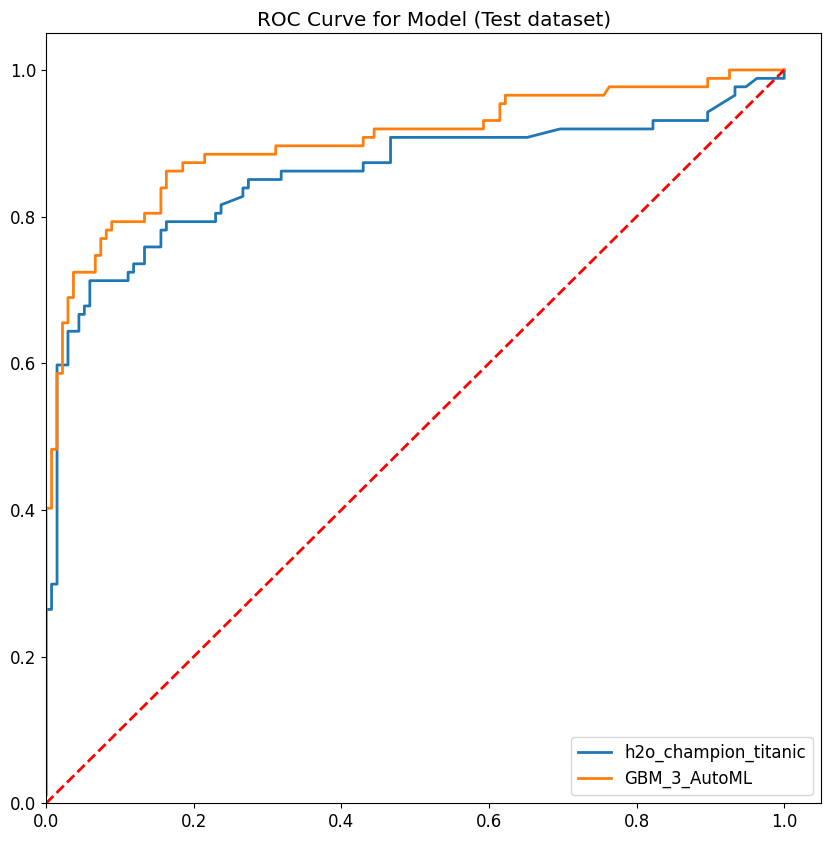

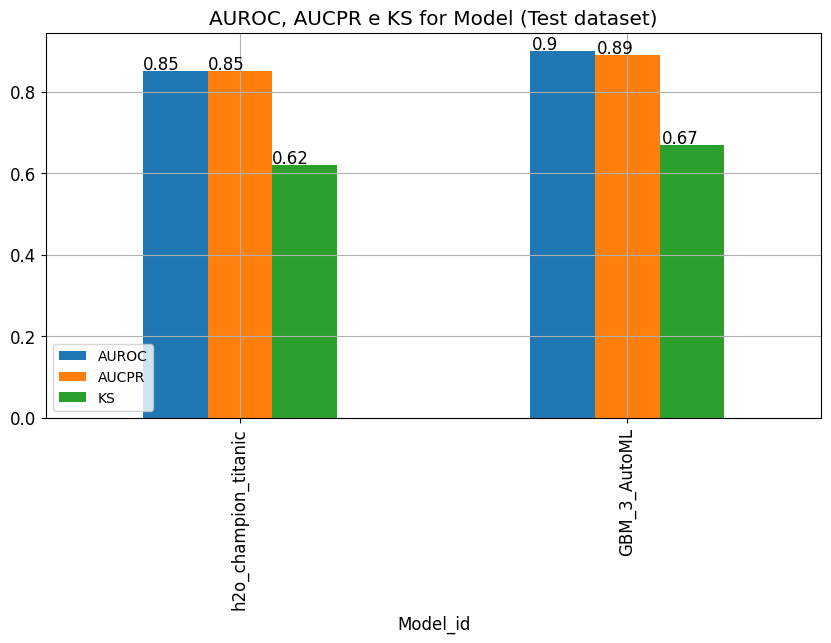

In [26]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if (isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator)) | (isinstance(i, h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator)):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

## 4.4 Choose the best model among all tested

In [27]:
sort_metric_best_model='AUCPR'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : AUCPR


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,GBM_3_AutoML_1_20220917_194024,0.654049,0.902214,0.897827,0.366738,0.676,0.497483
1,0,h2o_champion_titanic_propensity_survive_v18_20220917_193952,0.550180,0.858238,0.857752,0.456765,0.626,0.550180



BEST MODEL: GBM_3_AutoML_1_20220917_194024



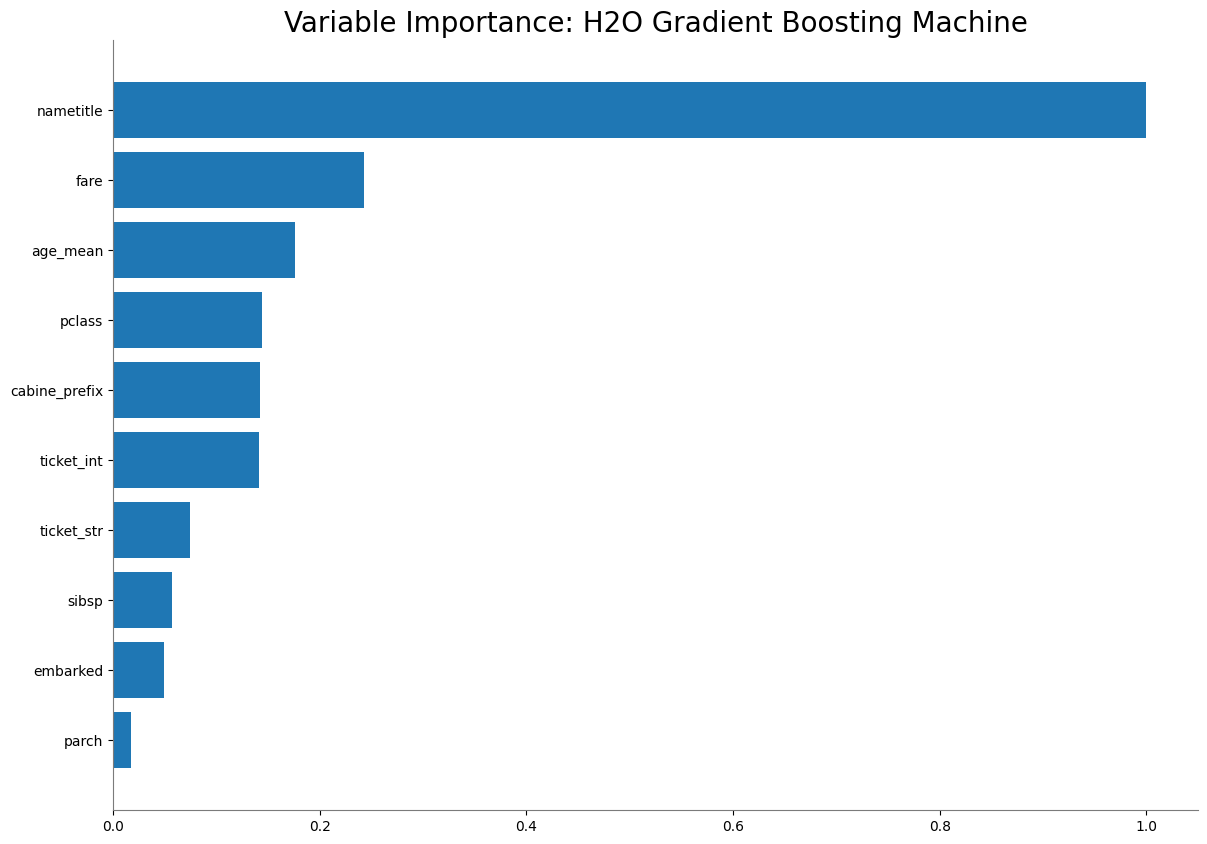

<Figure size 640x480 with 0 Axes>

In [34]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=0

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
    melhor_modelo.varimp_plot(50)
except Exception as e:
    print(e)
    melhor_modelo = modelos_testados.iloc[posicao_melhor_modelo, 0]
    (print("\n"+ "BEST MODEL: " + str(melhor_modelo) + "\n"))
    print("Warning: This model doesn't have variable importances")

## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [50]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True).to_list()
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [49]:
melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True).to_list()

['nametitle',
 'fare',
 'age_mean',
 'pclass',
 'cabine_prefix',
 'ticket_int',
 'ticket_str',
 'sibsp',
 'embarked',
 'parch']

In [40]:
df_features_sorted

0        nametitle
1             fare
2         age_mean
3           pclass
4    cabine_prefix
5       ticket_int
6       ticket_str
7            sibsp
8         embarked
9            parch
Name: 0, dtype: object

In [47]:
selected_features

['pclass',
 'embarked',
 'cabine_prefix',
 'ticket_str',
 'nametitle',
 'fare',
 'sibsp',
 'parch',
 'age_mean',
 'ticket_int']

In [51]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i]
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'Test_Dataset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'Test_Dataset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'Test_Dataset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'Test_Dataset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'Test_Dataset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


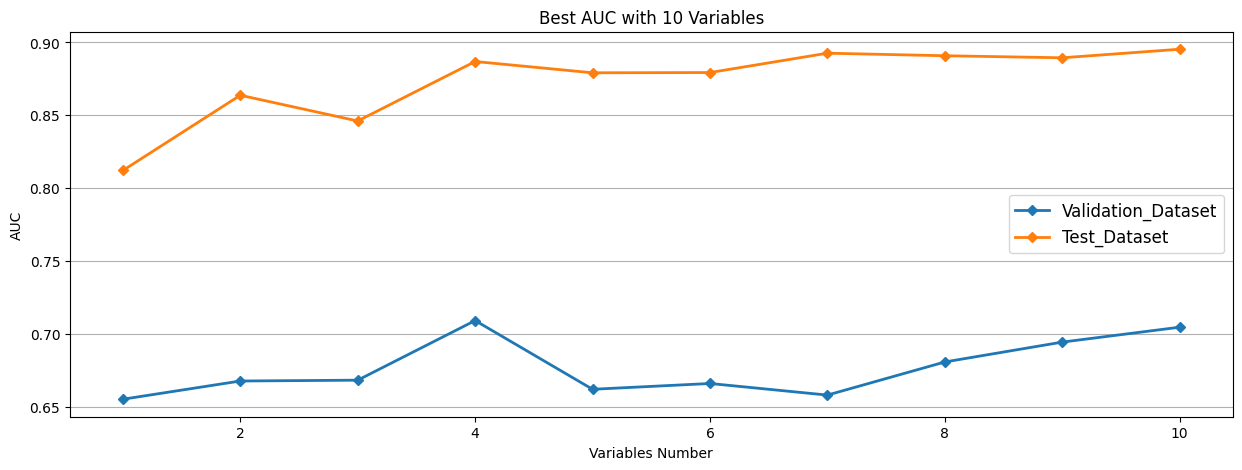

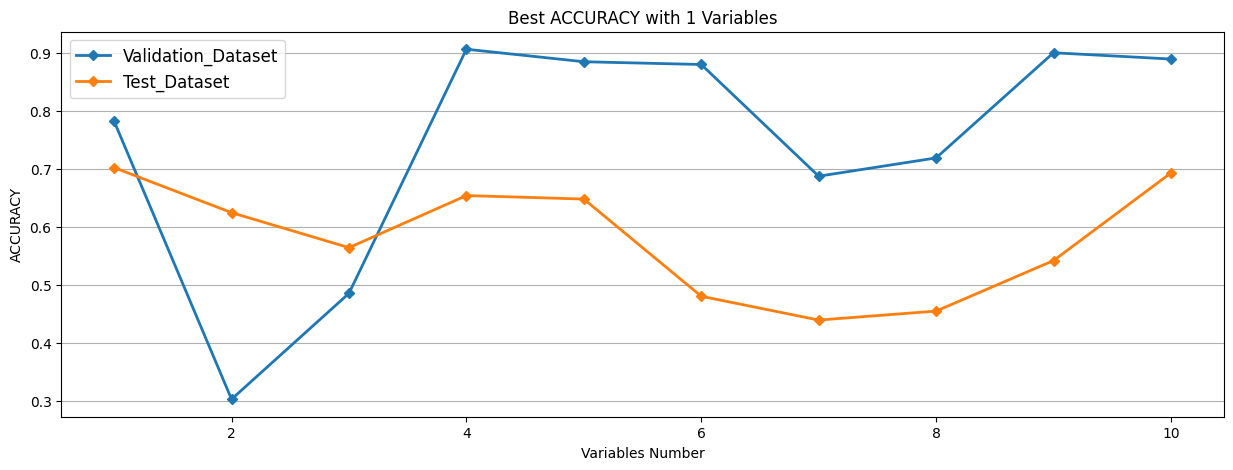

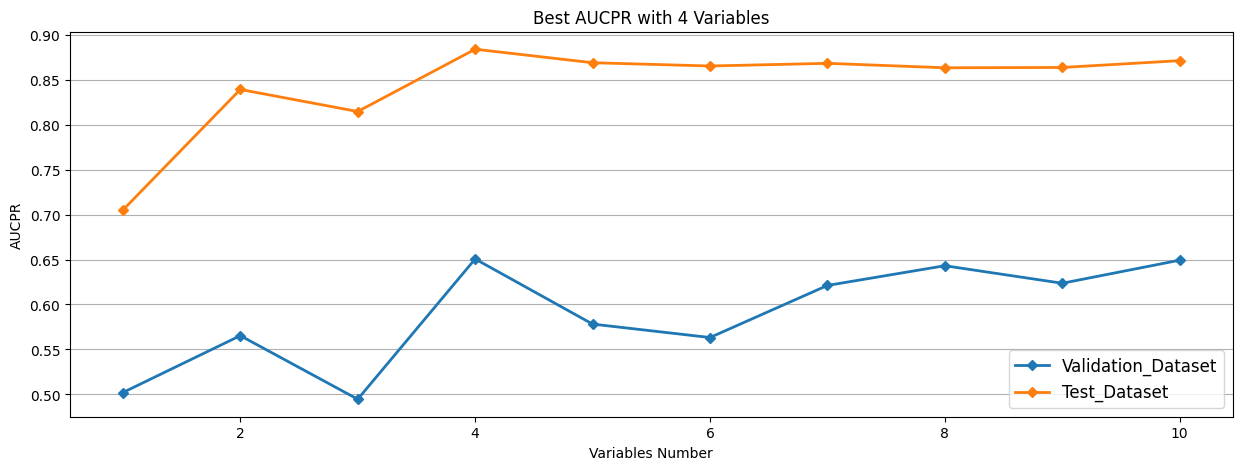

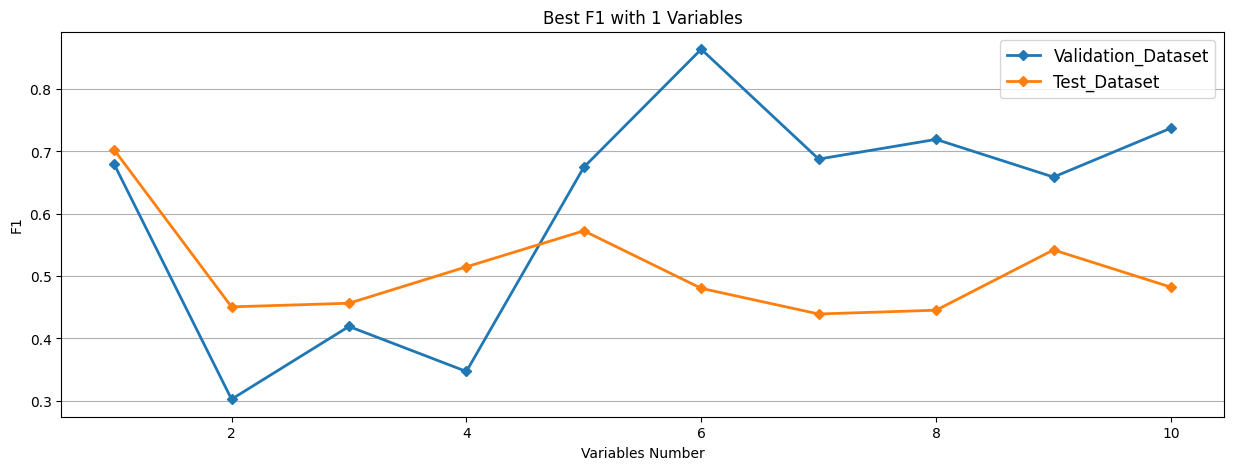

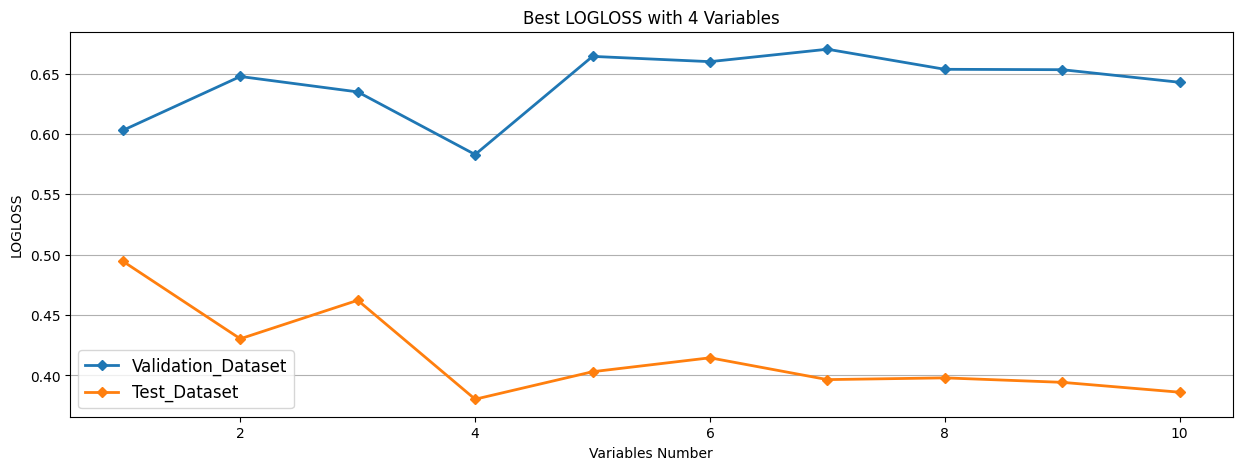

In [52]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [62]:
print('Consider using only the following variables: '+ str(df_features_sorted[0:int(max_oot_filtro)]))

Consider using only the following variables: ['nametitle', 'fare', 'age_mean', 'pclass']


# 5. Exporting the best model to Deploy

In [63]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    src_path = "%s/models/candidates/%s.py" % (OutputPath, ModelId)
    dst_path = "%s/models/best/%s.py" % (OutputPath, ModelId)
    shutil.copy(src_path, dst_path)
    print('path_sagemaker_model: ' + str(dst_path))

path_model_mojo: /home/sagemaker-user/FIEP-Modelos-de-Aprendizado-e-Arquiteturas-Cloud/output_model/models/best/GBM_3_AutoML_1_20220917_194024.zip


Detected 1 unused columns in the input data set: {}


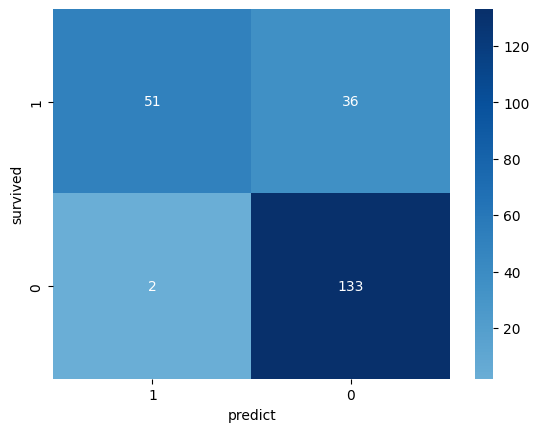

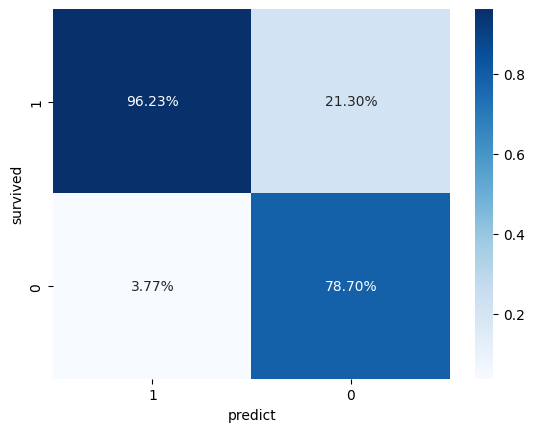

In [64]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 5.1 Cleaning Resources

In [66]:
# sm.delete_endpoint(EndpointName=ep_name)
# sm.delete_endpoint_config(EndpointConfigName=epc_name)

# 6. Save final dataset with predictions into S3 to explain the model

In [67]:
csv_buffer = StringIO()
df_predict.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/%s.csv' % (ModelName+'_scored', ModelName+'_scored')).put(Body=csv_buffer.getvalue())
del csv_buffer

In [69]:
glue = my_boto3_session.client('glue', region_name="us-east-1")

try:
    glue.delete_table(
        DatabaseName='datascience',
        Name=ModelName+'_scored'
    )
except:
    print("table does not exist")   

glue.update_crawler(Name='data-science-lab',
                    Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName+'_scored'),
                               'Exclusions': []}]})

glue.start_crawler(Name='data-science-lab')

table does not exist


{'ResponseMetadata': {'RequestId': '08be5629-aeb1-440c-b70e-8c3858ff2aab',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 17 Sep 2022 20:17:05 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '08be5629-aeb1-440c-b70e-8c3858ff2aab'},
  'RetryAttempts': 0}}